# make_tides:
## Make tides
##### Version id:
 v1    first go at converting https://github.com/dgwyther/ROMSForcingCreator/blob/master/tides/make_tides.m
 

In [1]:

run ='wilkes'
vers='2.5km'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks





# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask,smoothRegion,minWCTRegion

# Set model vertical coordinate settings

# N=31
# Vtransform=2
# Vstretching=4
# theta_s=4
# theta_b=1
# Tcline=300
# hc=Tcline # if Vtransform==2, hc=Tcline



# set user parameter and call main routine
#grd_file = os.path.join(data_dir,'proc',run+'_grd.nc')
grd_file = os.path.join(data_dir,'proc','wilkes_2.5km_v1_grd.nc')
out_file = os.path.join(data_dir,'proc',run+'_'+vers+'_tides.nc')


In [2]:
# load grid file
grd = xr.open_dataset(grd_file)

In [3]:
# import necessary TMD modules

import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities

import pyproj

In [4]:
# corrrect some wierdness in teh cats2008_v2023 file from Chad
import os
if os.path.isfile('../data/raw/CATS2008_v2023/CATS2008_v2023_orig.nc'):
    print('not overwriting, already existing')
else:
    !cp -p ../data/raw/CATS2008_v2023/CATS2008_v2023.nc ../data/raw/CATS2008_v2023/CATS2008_v2023_orig.nc
cats2008_v2023 = xr.open_dataset('../data/raw/CATS2008_v2023/CATS2008_v2023_orig.nc')

cats2008_v2023['uRe'] = cats2008_v2023.URe
cats2008_v2023['uIm'] = cats2008_v2023.UIm

cats2008_v2023['vRe'] = cats2008_v2023.VRe
cats2008_v2023['vIm'] = cats2008_v2023.VIm


cats2008_v2023.to_netcdf('../data/raw/CATS2008_v2023/CATS2008_v2023.nc')

not overwriting, already existing


/tmp/ipykernel_2555/4253609747.py:16: SerializationWarning: saving variable hRe with floating point data as an integer dtype without any _FillValue to use for NaNs
  cats2008_v2023.to_netcdf('../data/raw/CATS2008_v2023/CATS2008_v2023.nc')
/tmp/ipykernel_2555/4253609747.py:16: SerializationWarning: saving variable hIm with floating point data as an integer dtype without any _FillValue to use for NaNs
  cats2008_v2023.to_netcdf('../data/raw/CATS2008_v2023/CATS2008_v2023.nc')


In [5]:
# available model list
model_list = sorted(pyTMD.io.model.global_current() + pyTMD.io.model.antarctic_current())
model_list

['CATS0201',
 'CATS2008',
 'CATS2008-v2023',
 'FES2014',
 'HAMTIDE11',
 'TPXO7.2',
 'TPXO8-atlas',
 'TPXO9-atlas',
 'TPXO9-atlas-v2',
 'TPXO9-atlas-v3',
 'TPXO9-atlas-v4',
 'TPXO9-atlas-v5',
 'TPXO9.1']

In [6]:

# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'CATS2008-v2023'
TMDwidgets.atlas.value = 'netcdf'
TMDwidgets.compress.value = False
TMDwidgets.datepick.value = datetime.date(2018, 1, 1)
TMDwidgets.directory.value = '../data/raw/'
# TMDwidgets.VBox([
#     TMDwidgets.directory,
#     TMDwidgets.model,
#     TMDwidgets.atlas,
#     TMDwidgets.compress,
#     TMDwidgets.datepick
# ])

In [7]:
# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    format=TMDwidgets.atlas.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

In [8]:
lon,lat = grd.lon_rho.values.flatten(),grd.lat_rho.values.flatten()

In [9]:
model.model_file

PosixPath('../data/raw/CATS2008_v2023/CATS2008_v2023.nc')

In [10]:
# convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = TMDwidgets.datepick.value
tide_time = pyTMD.time.convert_calendar_dates(YMD.year, YMD.month,
    YMD.day, hour=np.arange(24))
# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

# save tide currents
tide = {}
# iterate over u and v currents
for TYPE in model.type:
    # read tidal constants and interpolate to grid points
    if model.format in ('OTIS','ATLAS','TMD3'):
        amp,ph,D,constituents = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file,
            model.model_file, model.projection, type=TYPE,
            method='spline', grid=model.format)
        DELTAT = np.zeros_like(tide_time)

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


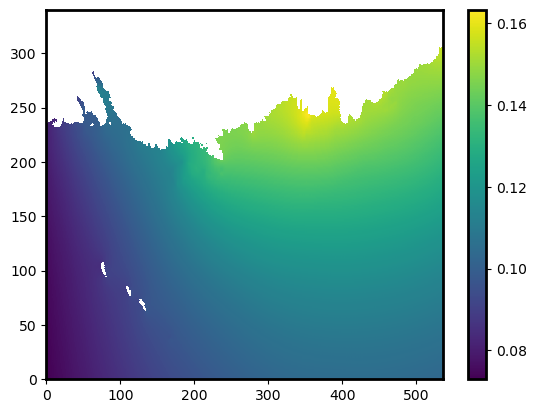

In [11]:
# reshape extracted constituents to actual size
amp_3d =np.reshape(amp,(*grd.lat_rho.shape,10))
ph_3d =np.reshape(ph,(*grd.lat_rho.shape,10))
print(constituents)
plt.pcolormesh(amp_3d[:,:,1])
plt.colorbar()

In [12]:
def _constituent_parameters(c: str, **kwargs):
    """
    Loads parameters for a given tidal constituent

    Parameters
    ----------
    c: str
        tidal constituent ID
    raise_error: bool, default False
        Raise exception if constituent is unsupported

    Returns
    -------
    amplitude: float
        amplitude of equilibrium tide for tidal constituent (meters)
    phase: float
        phase of tidal constituent (radians)
    omega: float
        angular frequency of constituent (radians)
    alpha: float
        load love number of tidal constituent
    species: float
        spherical harmonic dependence of quadrupole potential

    References
    ----------
    .. [1] G. D. Egbert and S. Y. Erofeeva, "Efficient Inverse Modeling of
        Barotropic Ocean Tides," *Journal of Atmospheric and Oceanic
        Technology*, 19(2), 183--204, (2002).
        `doi: 10.1175/1520-0426(2002)019<0183:EIMOBO>2.0.CO;2`__

    .. __: https://doi.org/10.1175/1520-0426(2002)019<0183:EIMOBO>2.0.CO;2
    """
    # default keyword arguments
    kwargs.setdefault('raise_error', False)
    # constituents array that are included in tidal program
    cindex = ['m2', 's2', 'k1', 'o1', 'n2', 'p1', 'k2', 'q1', '2n2', 'mu2',
        'nu2', 'l2', 't2', 'j1', 'm1', 'oo1', 'rho1', 'mf', 'mm', 'ssa',
        'm4', 'ms4', 'mn4', 'm6', 'm8', 'mk3', 's6', '2sm2', '2mk3',
        'msf', 'sa', 'mt', '2q1']
    # species type (spherical harmonic dependence of quadrupole potential)
    _species = np.array([2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    # Load Love numbers
    # alpha = correction factor for first order load tides
    _alpha = np.array([0.693, 0.693, 0.736, 0.695, 0.693, 0.706, 0.693,
        0.695, 0.693, 0.693, 0.693, 0.693, 0.693, 0.695, 0.695, 0.695, 0.695,
        0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693,
        0.693, 0.693, 0.693, 0.693, 0.693, 0.693])
    # omega: angular frequency of constituent, in radians
    _omega = np.array([1.405189e-04, 1.454441e-04, 7.292117e-05, 6.759774e-05,
        1.378797e-04, 7.252295e-05, 1.458423e-04, 6.495854e-05, 1.352405e-04,
        1.355937e-04, 1.382329e-04, 1.431581e-04, 1.452450e-04, 7.556036e-05,
        7.028195e-05, 7.824458e-05, 6.531174e-05, 0.053234e-04, 0.026392e-04,
        0.003982e-04, 2.810377e-04, 2.859630e-04, 2.783984e-04, 4.215566e-04,
        5.620755e-04, 2.134402e-04, 4.363323e-04, 1.503693e-04, 2.081166e-04,
        4.925200e-06, 1.990970e-07, 7.962619e-06, 6.231934e-05])
    # Astronomical arguments (relative to t0 = 1 Jan 0:00 1992)
    # phases for each constituent are referred to the time when the phase of
    # the forcing for that constituent is zero on the Greenwich meridian
    _phase = np.array([1.731557546, 0.000000000, 0.173003674, 1.558553872,
        6.050721243, 6.110181633, 3.487600001, 5.877717569, 4.086699633,
        3.463115091, 5.427136701, 0.553986502, 0.052841931, 2.137025284,
        2.436575100, 1.929046130, 5.254133027, 1.756042456, 1.964021610,
        3.487600001, 3.463115091, 1.731557546, 1.499093481, 5.194672637,
        6.926230184, 1.904561220, 0.000000000, 4.551627762, 3.809122439,
        4.551627762, 6.232786837, 3.720064066, 3.91369596])
    # amplitudes of equilibrium tide in meters
    # _amplitude = np.array([0.242334,0.112743,0.141565,0.100661,0.046397,
    _amplitude = np.array([0.2441, 0.112743, 0.141565, 0.100661, 0.046397,
        0.046848, 0.030684, 0.019273, 0.006141, 0.007408, 0.008811, 0.006931,
        0.006608, 0.007915, 0.007915, 0.004338, 0.003661, 0.042041, 0.022191,
        0.019567, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.003681, 0.003104,
        0.008044, 0.002565])

    # map between input constituent and cindex
    j = [j for j,val in enumerate(cindex) if (val == c.lower())]
    # set the values for the constituent
    if j:
        amplitude, = _amplitude[j]
        phase, = _phase[j]
        omega, = _omega[j]
        alpha, = _alpha[j]
        species, = _species[j]
    elif kwargs['raise_error']:
        raise ValueError(f'Unsupported constituent {c}')
    else:
        amplitude = 0.0
        phase = 0.0
        omega = 0.0
        alpha = 0.0
        species = 0
    # return the values for the constituent
    return (amplitude, phase, omega, alpha, species)

In [13]:
# make vector with all hourly periods
period = np.ones((len(constituents),1))*np.NaN
for i,cons in enumerate(constituents):
    print(cons)
    _,_,angfreq,_,_ = _constituent_parameters(cons)
    T = 2*np.pi/angfreq / (60*60)
    print(T)
    period[i] = T
    
period = period.squeeze()

m2
12.420601442185568
s2
12.000000357486687
n2
12.658348197699366
k2
11.967236199609644
k1
23.934465834740852
o1
25.81934325014904
p1
24.0658888254591
q1
26.868357139712955
mf
327.85987376382195
mm
661.3099621075816


In [14]:
# Do we want to only force the boundaries?
only_force_bnds = 1
if only_force_bnds: # only force boundaries
    tmask = np.zeros(grd.lat_rho.shape)
    tmask[:,0] = 1
    tmask[:,-1] = 1
    tmask[0, ]= 1
    tmask[-1,] = 1
    
        
    # add extra buffer
    # tmask[0,:]=0
    # tmask[-1,:]=0
    # tmask[:,-1]=0
    tmask = tmask*0.5
    
    # under_ice_mask = grd.mask_rho[grd.zice < 0] = 0; # don't force under ice shelves
    mask_nozice = grd.mask_rho.where(grd.zice>=0,0) * grd.mask_rho
    
    tmask = tmask*grd.mask_rho*mask_nozice

    
    tmask_big=np.ones((len(grd.eta_rho),len(grd.xi_rho),10))*np.NaN    
    for nn in range(len(constituents)):
        tmask_big[:,:,nn] = tmask
# elif 0: # force whole surface
#     # mask_zice = ncread(grdname,'mask_zice')';
#     # tmask = ones(pp,qq);
#     # %ma = mask_rho;
#     # mask_rho(mask_zice == 1) = 0;

# plt.figure(figsize=(10,10))
# plt.pcolormesh(tmask*grd.mask_rho*mask_nozice)
# plt.axis((-10,910,-10,800))
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(10,10))
# plt.pcolormesh(mask_nozice)
# plt.axis((-10,910,-10,800))
# plt.colorbar()

# plt.figure(figsize=(10,10))
# plt.pcolormesh(mask_nozice*grd.zice)
# plt.axis((-10,910,-10,800))
# plt.colorbar()
    # mask out ice shelves and non-ocean, and fill nan with 0.
    amp_3d_unm = amp_3d.copy()
    ph_3d_unm = ph_3d.copy()
    amp_3d = amp_3d.filled(fill_value=0)*tmask_big
    ph_3d = ph_3d.filled(fill_value=0)*tmask_big



In [15]:
# check for nans and other bad values
variables = ['tide_Eamp','tide_Ephase','tide_period']



for arr_name in variables:
    arr = locals().get(arr_name)
    if arr is not None:
        if np.isnan(arr).any():
            print(f"Warning: NaN found in array '{arr_name}'")
    else:
        print('no NaN in '+arr_name)
            


no NaN in tide_Eamp
no NaN in tide_Ephase
no NaN in tide_period


In [16]:

tide_Eamp_da = xr.DataArray(amp_3d,name='tide_Eamp',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation amplitude',
 'units': 'metres',
 'field': 'tide_Eamp, scalar'})
tide_Ephase_da = xr.DataArray(ph_3d,name='tide_Ephase',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation phase angle',
'units': 'degrees, time of maximum elevation with respect to chosen time origin',
 'field': 'tide_Ephase, scalar'})
tide_Eamp_unmasked_da = xr.DataArray(amp_3d_unm,name='tide_Eamp_unmasked',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation amplitude, unmasked',
 'units': 'metres',
 'field': 'tide_Eamp, scalar'})
tide_Ephase_unmasked_da = xr.DataArray(ph_3d_unm,name='tide_Ephase_unmasked',dims=['eta_rho','xi_rho','tide_period'],attrs={'long_name': 'tidal elevation phase angle, unmasked',
'units': 'degrees, time of maximum elevation with respect to chosen time origin',
 'field': 'tide_Ephase, scalar'})
tide_period_da = xr.DataArray(period,name='tide_period',dims=['tide_period'],attrs={ 'long_name': 'tide angular period',
'units':'hours',
'field':'tide_period, scalar'})



tds = xr.Dataset({'tide_Eamp':tide_Eamp_da,
                'tide_Ephase':tide_Ephase_da,
                'tide_Eamp_unmasked':tide_Eamp_unmasked_da,
                'tide_Ephase_unmasked':tide_Ephase_unmasked_da,
                'tide_period':tide_period_da},
               attrs={'title':run+'_'+vers+'_tides.nc',
                      'history': 'TIDE file using make_tide.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file',
                      'grd_file':grd_file,
                      'components':constituents})

tds = tds.assign_coords({'tide_period':tide_period_da})

# reorganise dimensions
tds = tds.transpose('tide_period','eta_rho','xi_rho')

In [17]:
print('saving to',out_file)
tds.to_netcdf(out_file)

saving to /home/woden/Documents/wilkes-setup/data/proc/wilkes_2.5km_tides.nc


In [18]:
# tds.tide_Eamp.isel(eta_rho=0,n_constituent=0).plot()
# plt.show()
# tmask.plot()
# plt.ylim((-5,15))
# plt.show()
# plt.pcolormesh(mask_nozice)
# plt.ylim((-5,15))
# plt.show()
# plt.pcolormesh(grd.zice<0)
# plt.ylim((-5,15))


In [19]:

# plt.figure(figsize=(20,20))
# tds.tide_Eamp.isel(n_constituent=3).plot()
# plt.axis((-10,910,-10,760))
# plt.show()
# plt.figure(figsize=(20,20))
# tds.tide_Eamp_unmasked.isel(n_constituent=3).plot()
# plt.axis((-10,910,-10,760))

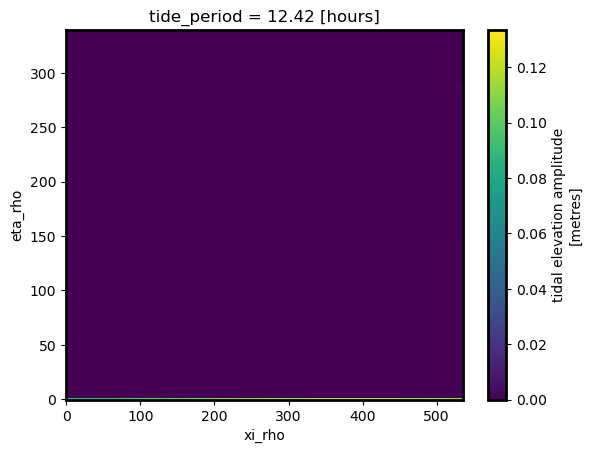

In [20]:
tds.tide_Eamp.isel(tide_period=0).plot()